In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import Plate.plate_fem as pt
from Fluid import F2D
import numpy as np
import time
import matplotlib.pyplot as plt

# Specify geometry
aspect_ratio = 10
l_c = 500e-6  # length of beam in m
h_c = 5e-6  # thickness of the beam in m
w_c = l_c / aspect_ratio  # width in m

# Specify fluid -> Water
mu_f = 890e-6  # Fluid dynamic viscosity in Pa.s
rho_f = 997  # Fluid density in kg/m^3
nu_f = mu_f / rho_f  # Fluid kinematic viscosity in m^2/s

# Specify material of plate -> Silicon
e_c = 169E9  # Young's Modulus in Pa
rho_c = 2.33E3  # Density in kg/m^3
nu_c = 0.3  # Poisson Coefficient, dimensionless


# Basic objects, shared by all classes
geometry = pt.Geometry(l_c, w_c, h_c)
mat = pt.Material(e_c, rho_c, nu_c)
fluid = F2D.Fluid(mu_f, rho_f)

# Mesh specification -> To solve Kirchhoff-Love plate equation
n_x = 64  # Number of elements in length l_c (x-direction)
n_y = int(n_x/aspect_ratio) # Number of elements in width w_c (y-direction)

# Fluid grid specification -> To solve the fluid problem
n_x_fluid = 32  # Number of elements in length l_c (x-direction)
n_y_fluid = 4*n_x_fluid  # Number of elements in width w_c (y-direction)





In [2]:
plate = pt.InteriorPenalty()
plate.geometry = geometry
plate.mat = mat
plate.meshing(n_x, n_y, 'crossed')
plate.preliminary_setup()
#plate.k_and_m_matrices()
plate.setup_eigenvalues_problem()


 Setup Mesh 64 x 6.


In [3]:
vfi = F2D.F2D()
vfi.fluid = fluid
vfi.fem = plate
vfi.geometry = geometry
vfi.setup_quadrature(n_x_fluid, n_y_fluid)

# Solve for VFI dynamics in the frequency domain

In [4]:

# Spectral analysis
n_f = 200  # Number of steps in frequency
f_initial = 1e3  # Specify Initial frequency in Hz
f_final = 400e3  # Specify Final frequency in Hz, you can use the f_n in vacuum as an initial guess
#frequency = np.linspace(f_initial, f_final, n_f, endpoint=True)
frequency = np.logspace(np.log10(f_initial), np.log10(f_final), n_f, endpoint=True)
from tqdm import tqdm
import fenics as fe
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

In [5]:
row, col, val = fe.as_backend_type(plate.m_matrix.mat().getValuesCSR())
M_csr = sp.csr_matrix((val, col, row), dtype=complex)

row, col, val = fe.as_backend_type(plate.k_matrix.mat().getValuesCSR())
K_csr = sp.csr_matrix((val, col, row), dtype=complex)

L = np.array(plate.get_linear_form())

phi_2d = np.zeros(len(frequency), dtype=complex)

In [6]:
tt = time.time()
for ff in tqdm(range(n_f)):
    omega = 2*np.pi*frequency[ff]
    Fl_2d = vfi.get_h_force(omega)
    L_2d = K_csr - omega**2*M_csr + 1j*omega*Fl_2d
    phi = spsolve(L_2d, L)
    phi_2d[ff] = plate.get_point_value(phi)
    #if ff == 1:
    #    tt = (time.time() - tt)*(n_f - 2)
    #    print('Estimated remaining time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))

100%|█████████████████████████████████████████| 200/200 [00:40<00:00,  4.93it/s]


# Compare to Sader

In [7]:
import Fluid.Sader as Sader

probe = Sader.SaderMethod()
# specify geometry
probe.geometry = geometry
probe.fluid = fluid
probe.mat = mat
probe.frequency = frequency
probe.N_modes = 10
probe.n_x = 200
#w = probe.thermal_displacement()
#q_sader = probe.q_factor()
w = probe.get_displacement_per_force().T*w_c
w_sader = w


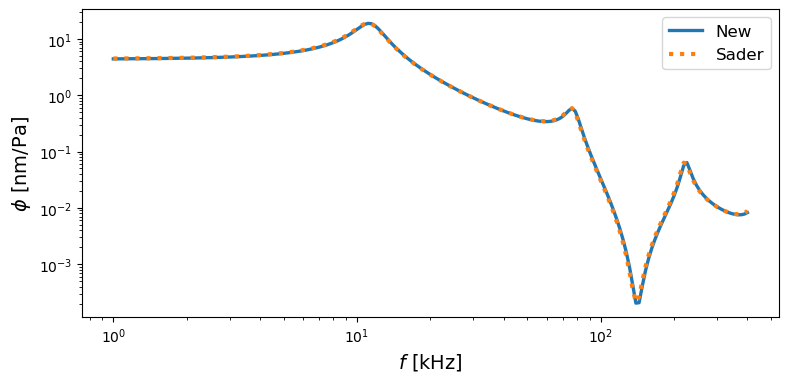

In [8]:
plt.figure(1, figsize=(9, 4))
plt.loglog(frequency/1e3, 1e9*np.abs(phi_2d), linewidth=2.4, label='New')
plt.loglog(frequency/1e3, 1e9*np.abs(w_sader[:, -1]), ':', linewidth=3,  label='Sader')
#plt.loglog(frequency/1e3, np.abs(phi_probe), '--', label='Old')
plt.legend(fontsize=12)
plt.xlabel('$f$ [kHz]', fontsize=14)
plt.ylabel(r'$\phi$ [nm/Pa]', fontsize=14)
plt.show()